In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('../..')
sys.path.append('../../lib/src/')
sys.path.append('../../TopographicVAE-master')
import torch
from torch import nn
import torch.nn.functional as F
import os
from itertools import islice
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, Encoder_ColorMNIST,Decoder_ColorMNIST
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(grid, color=False):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset

%reload_ext autoreload
%autoreload 2

!nvidia-smi

Thu Aug  1 17:05:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   47C    P8             11W /   70W |    3227MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([700, 10, 1, 64, 64])


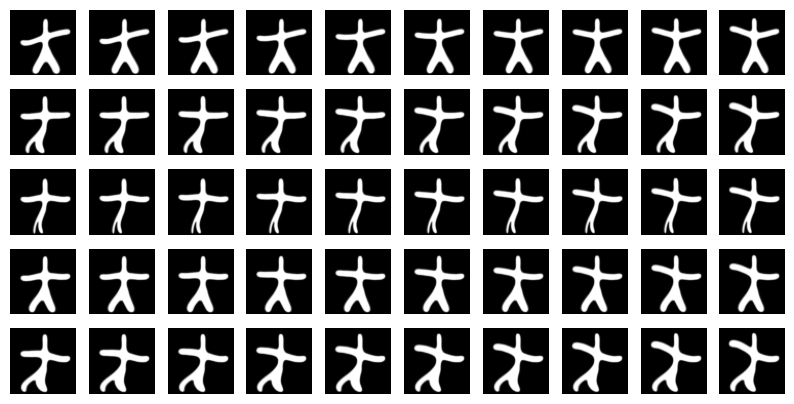

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load('starmen_data.pt')[:700].unsqueeze(2)
eval_data = torch.load('starmen_data.pt')[700:900].unsqueeze(2)
test_data = torch.load('starmen_data.pt')[900:].unsqueeze(2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

plot_sequence(train_data[:5], color=False)

In [21]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-08-01_16-38-44/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_2/checkpoints/epoch=99-step=1100.ckpt'

device = 'cpu'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data.reshape(-1,1,64,64), verbose = True, T_multiplier=1, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

h,w = 64, 64
input_dim = (1, h, w)
f = 32 #subsampling factor
latent_dim = 3* (h // f) * (w // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  2.5014681816101074
Building metric
Increasing T by  1
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [22]:
model_config = LVAE_IAF_Config(
    input_dim=(1, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    #########################
    warmup=0,
    #########################
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=200,
        learning_rate=5*1e-4,
        batch_size=32,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cpu'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=None, verbose = True, temp = temperature)

#model = LVAE_IAF(model_config, encoder, decoder).cuda()

Diffusion time steps  [999 888 777 666 555 444 333 222 111   0]
Running on  cpu
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


In [5]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="starmen_LLDM", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [23]:
optimizer = torch.optim.Adam(lldm.parameters(), lr=1e-3, eps = 1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer,
#     milestones=[50, 100, 150, 200],
#     gamma=10**(-1/4),
#     verbose=True
# )
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            callbacks=callbacks
        )

In [ ]:
# for p in lldm.parameters():
#     p.requires_grad = True
# for p in lldm.pretrained_vae.parameters():
#     p.requires_grad = False
# for p in lldm.pretrained_ldm.parameters():
#     p.requires_grad = False
# lldm = lldm.to('cuda')
# lldm = lldm.train()
trainer.train()

In [29]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-30_16-29-58/checkpoint_epoch_50/model.pt')['model_state_dict'])

<All keys matched successfully>

In [57]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
model = LitLDM.load_from_checkpoint('ldm_retrain/lightning_logs/version_0/checkpoints/epoch=99-step=3200.ckpt', ldm = latent_diffusion, vae = new_vae, latent_dim = latent_dim).to('cuda')
lldm.pretrained_ldm = model.ldm

for p in lldm.parameters():
    p.requires_grad = True
for p in lldm.pretrained_vae.parameters():
    p.requires_grad = False
for p in lldm.pretrained_ldm.parameters():
    p.requires_grad = False

36


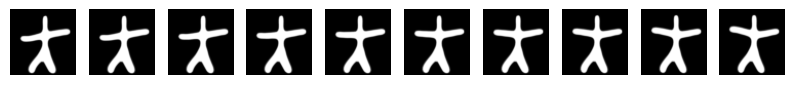

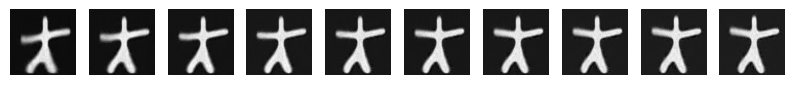

Reconstruction loss: 9.528152465820312


In [40]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
print(idx)
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 4)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [33]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 10, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([700, 10, 12])


PCA on the whole dataset (7000 data points)


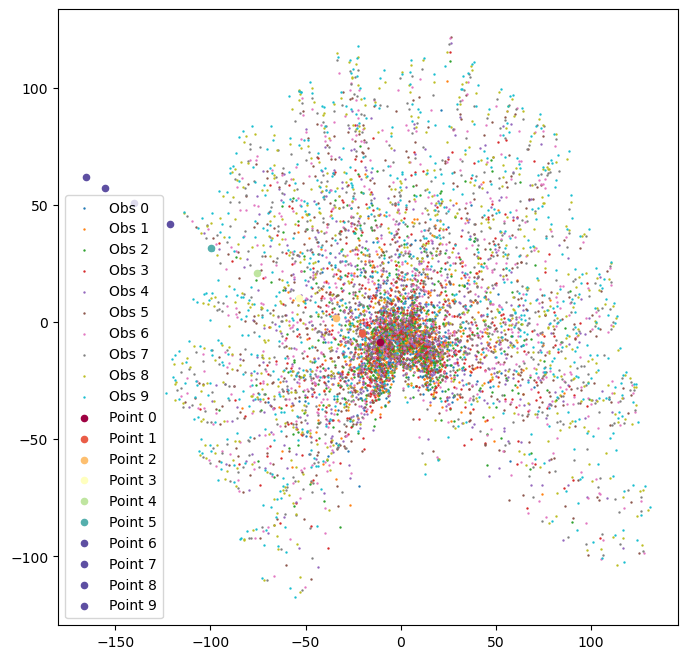

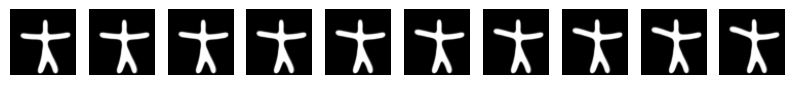

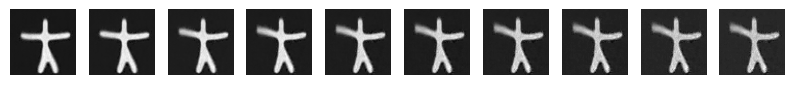

Reconstruction loss: 24.33401870727539


In [69]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cuda')
#torch.manual_seed(46)

###################
vi_index = 0
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 360
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

z_seq = z_seq.reshape(-1, latent_dim)
x_rec = lldm.decoder(z_seq).reconstruction

z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [49]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)

last_train_data = train_data[:, -1]
last_eval_data = eval_data[:, -1]


BATCH_SIZE = 256

last_train_loader = torch.utils.data.DataLoader(last_train_data, batch_size=BATCH_SIZE, num_workers = 12)
last_val_loader = torch.utils.data.DataLoader(last_eval_data, batch_size=800, num_workers = 12)


In [ ]:
import lightning as L
ldm = lldm.pretrained_ldm

#UNFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = True


n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-3
MAX_EPOCHS = 100


model = LitLDM(ldm = ldm, vae = new_vae, lr = lr).to(device)




trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm_retrain', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, last_train_loader, last_val_loader)

#REFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = False

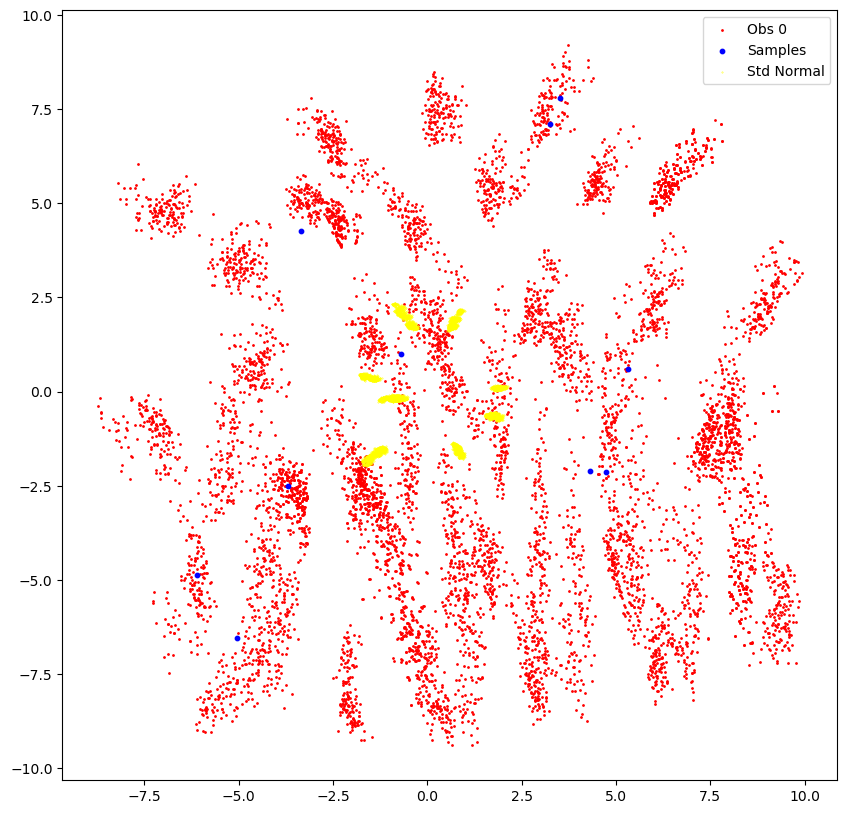

In [29]:
final_vae = final_vae.to(obs_data.device)
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Std Normal', s= 0.1, c = 'yellow')
plt.legend()
plt.show()

Running Kmedoids
Finding temperature
Best temperature found:  78.6722183227539
Building metric
Increasing T by  0.5
Sampling 10 points on the 2th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


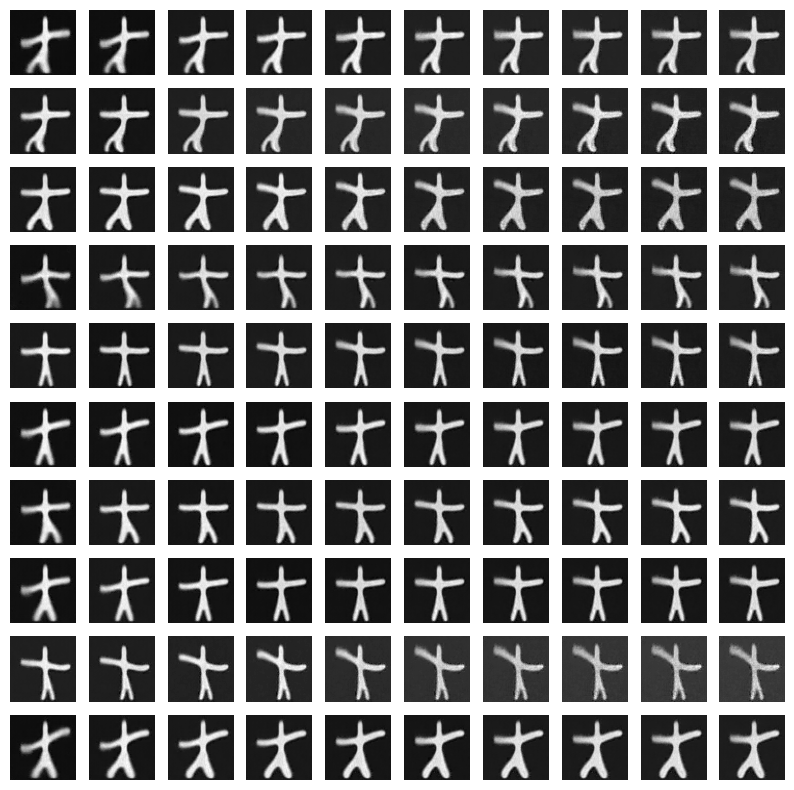

In [76]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index = 2, T_multiplier=0.5)
plot_sequence(recon_x)

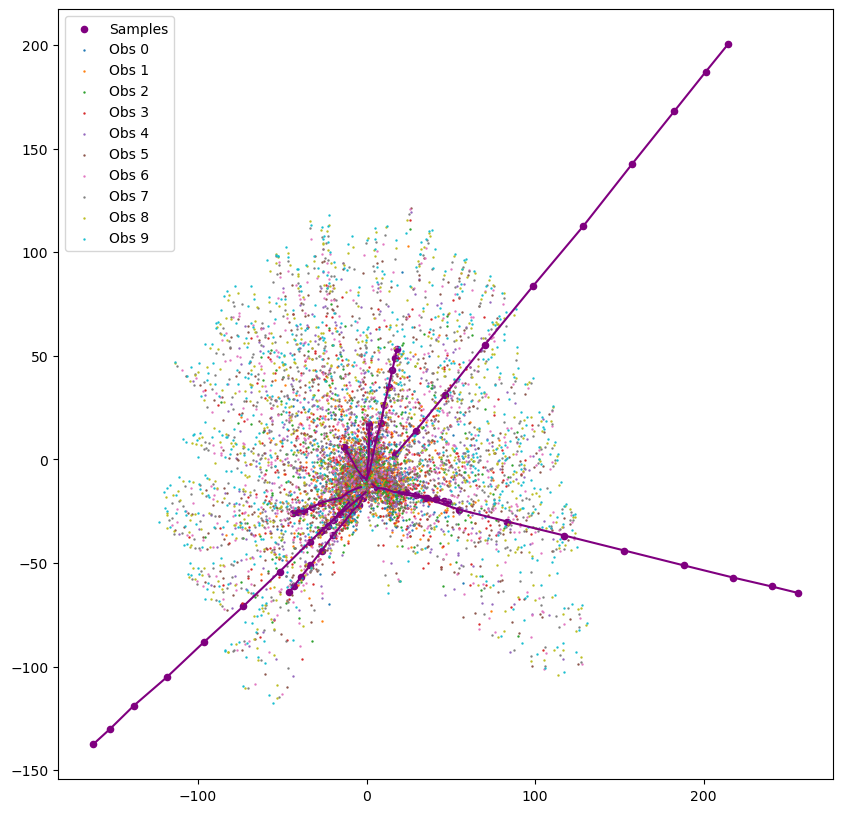

In [77]:
displayed_indexes = range(num_obs)  #range(num_obs)
n_samples = 10
NUM_OBS = 10

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
